In [1]:
from tqdm.auto import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import random
import cv2
from PIL import Image
pd.set_option('display.max_columns', None)
import albumentations
from albumentations.pytorch.transforms import ToTensorV2
import torch
import torchvision
import timm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

RANDOM_SEED = 15


/Users/bosstation/anaconda3/envs/dl/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.13 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations


## 1. Description
###  Objective
The primary goal of this project is to develop a deep learning model that can predict the "Pawpularity" score of pet images. Pawpularity is a metric used by PetFinder.my to gauge the appeal of a pet's photo to online browsers, which can influence the pet's chances of adoption.

In [2]:
# Load the metadata
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

# Print dataset sizes
print(f"Training set size: {len(train)}")
print(f"Test set size: {len(test)}")


# Print data types and non-null counts
print("\nDataset Info:")
train.info()

Training set size: 9912
Test set size: 8

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9912 entries, 0 to 9911
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Id             9912 non-null   object
 1   Subject Focus  9912 non-null   int64 
 2   Eyes           9912 non-null   int64 
 3   Face           9912 non-null   int64 
 4   Near           9912 non-null   int64 
 5   Action         9912 non-null   int64 
 6   Accessory      9912 non-null   int64 
 7   Group          9912 non-null   int64 
 8   Collage        9912 non-null   int64 
 9   Human          9912 non-null   int64 
 10  Occlusion      9912 non-null   int64 
 11  Info           9912 non-null   int64 
 12  Blur           9912 non-null   int64 
 13  Pawpularity    9912 non-null   int64 
dtypes: int64(13), object(1)
memory usage: 1.1+ MB


In [3]:
# Load and print dimensions of a few images
print("\nImage Dimensions:")
image_dir = './data/train'  # Update this to your image directory path
for i in range(5):  # Check first 5 images
    img_path = os.path.join(image_dir, train.loc[i, 'Id'] + '.jpg')
    with Image.open(img_path) as img:
        print(f"Image {i+1}: {img.size}")

# Print unique values in categorical columns
categorical_col = train.columns.tolist()[1:-1]
print("\nUnique values in categorical columns:")
for col in categorical_col:
    print(f"{col}: {train[col].unique()}")


Image Dimensions:
Image 1: (405, 720)
Image 2: (1032, 774)
Image 3: (720, 960)
Image 4: (405, 720)
Image 5: (540, 960)

Unique values in categorical columns:
Subject Focus: [0 1]
Eyes: [1 0]
Face: [1 0]
Near: [1 0]
Action: [0 1]
Accessory: [0 1]
Group: [1 0]
Collage: [0 1]
Human: [0 1]
Occlusion: [0 1]
Info: [0 1]
Blur: [0 1]


## 2. EDA

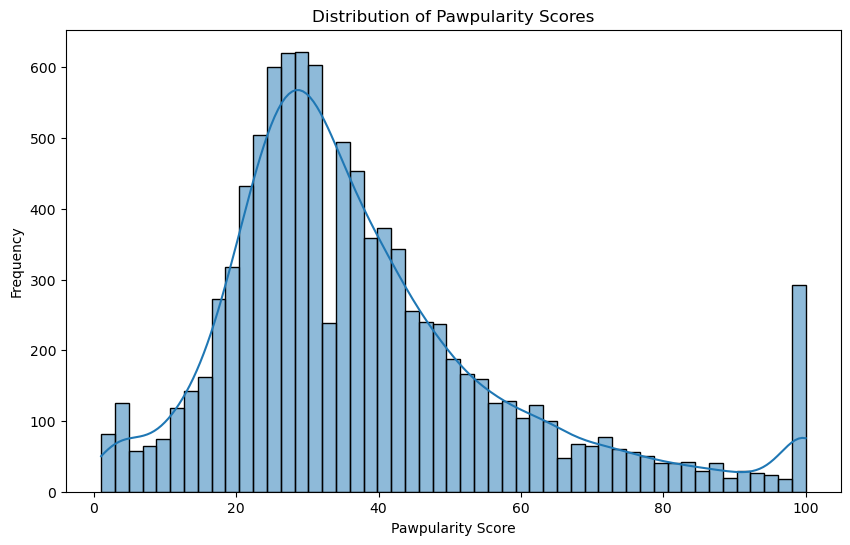

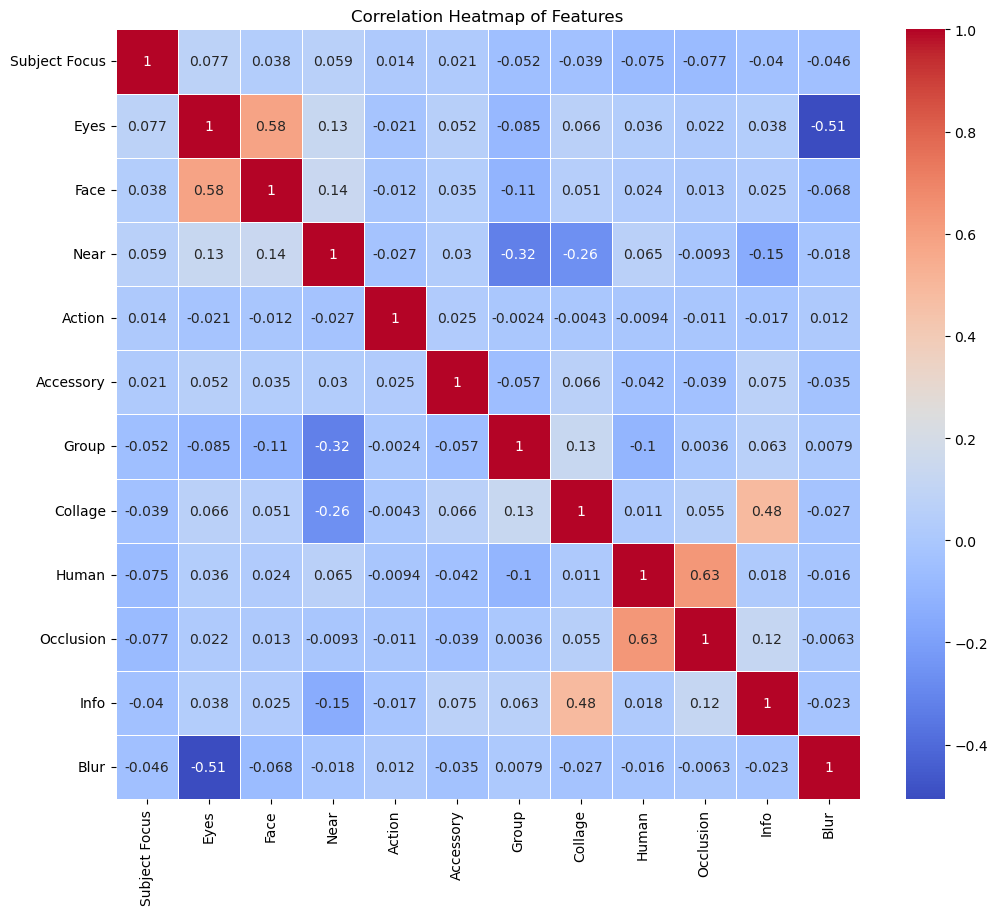

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

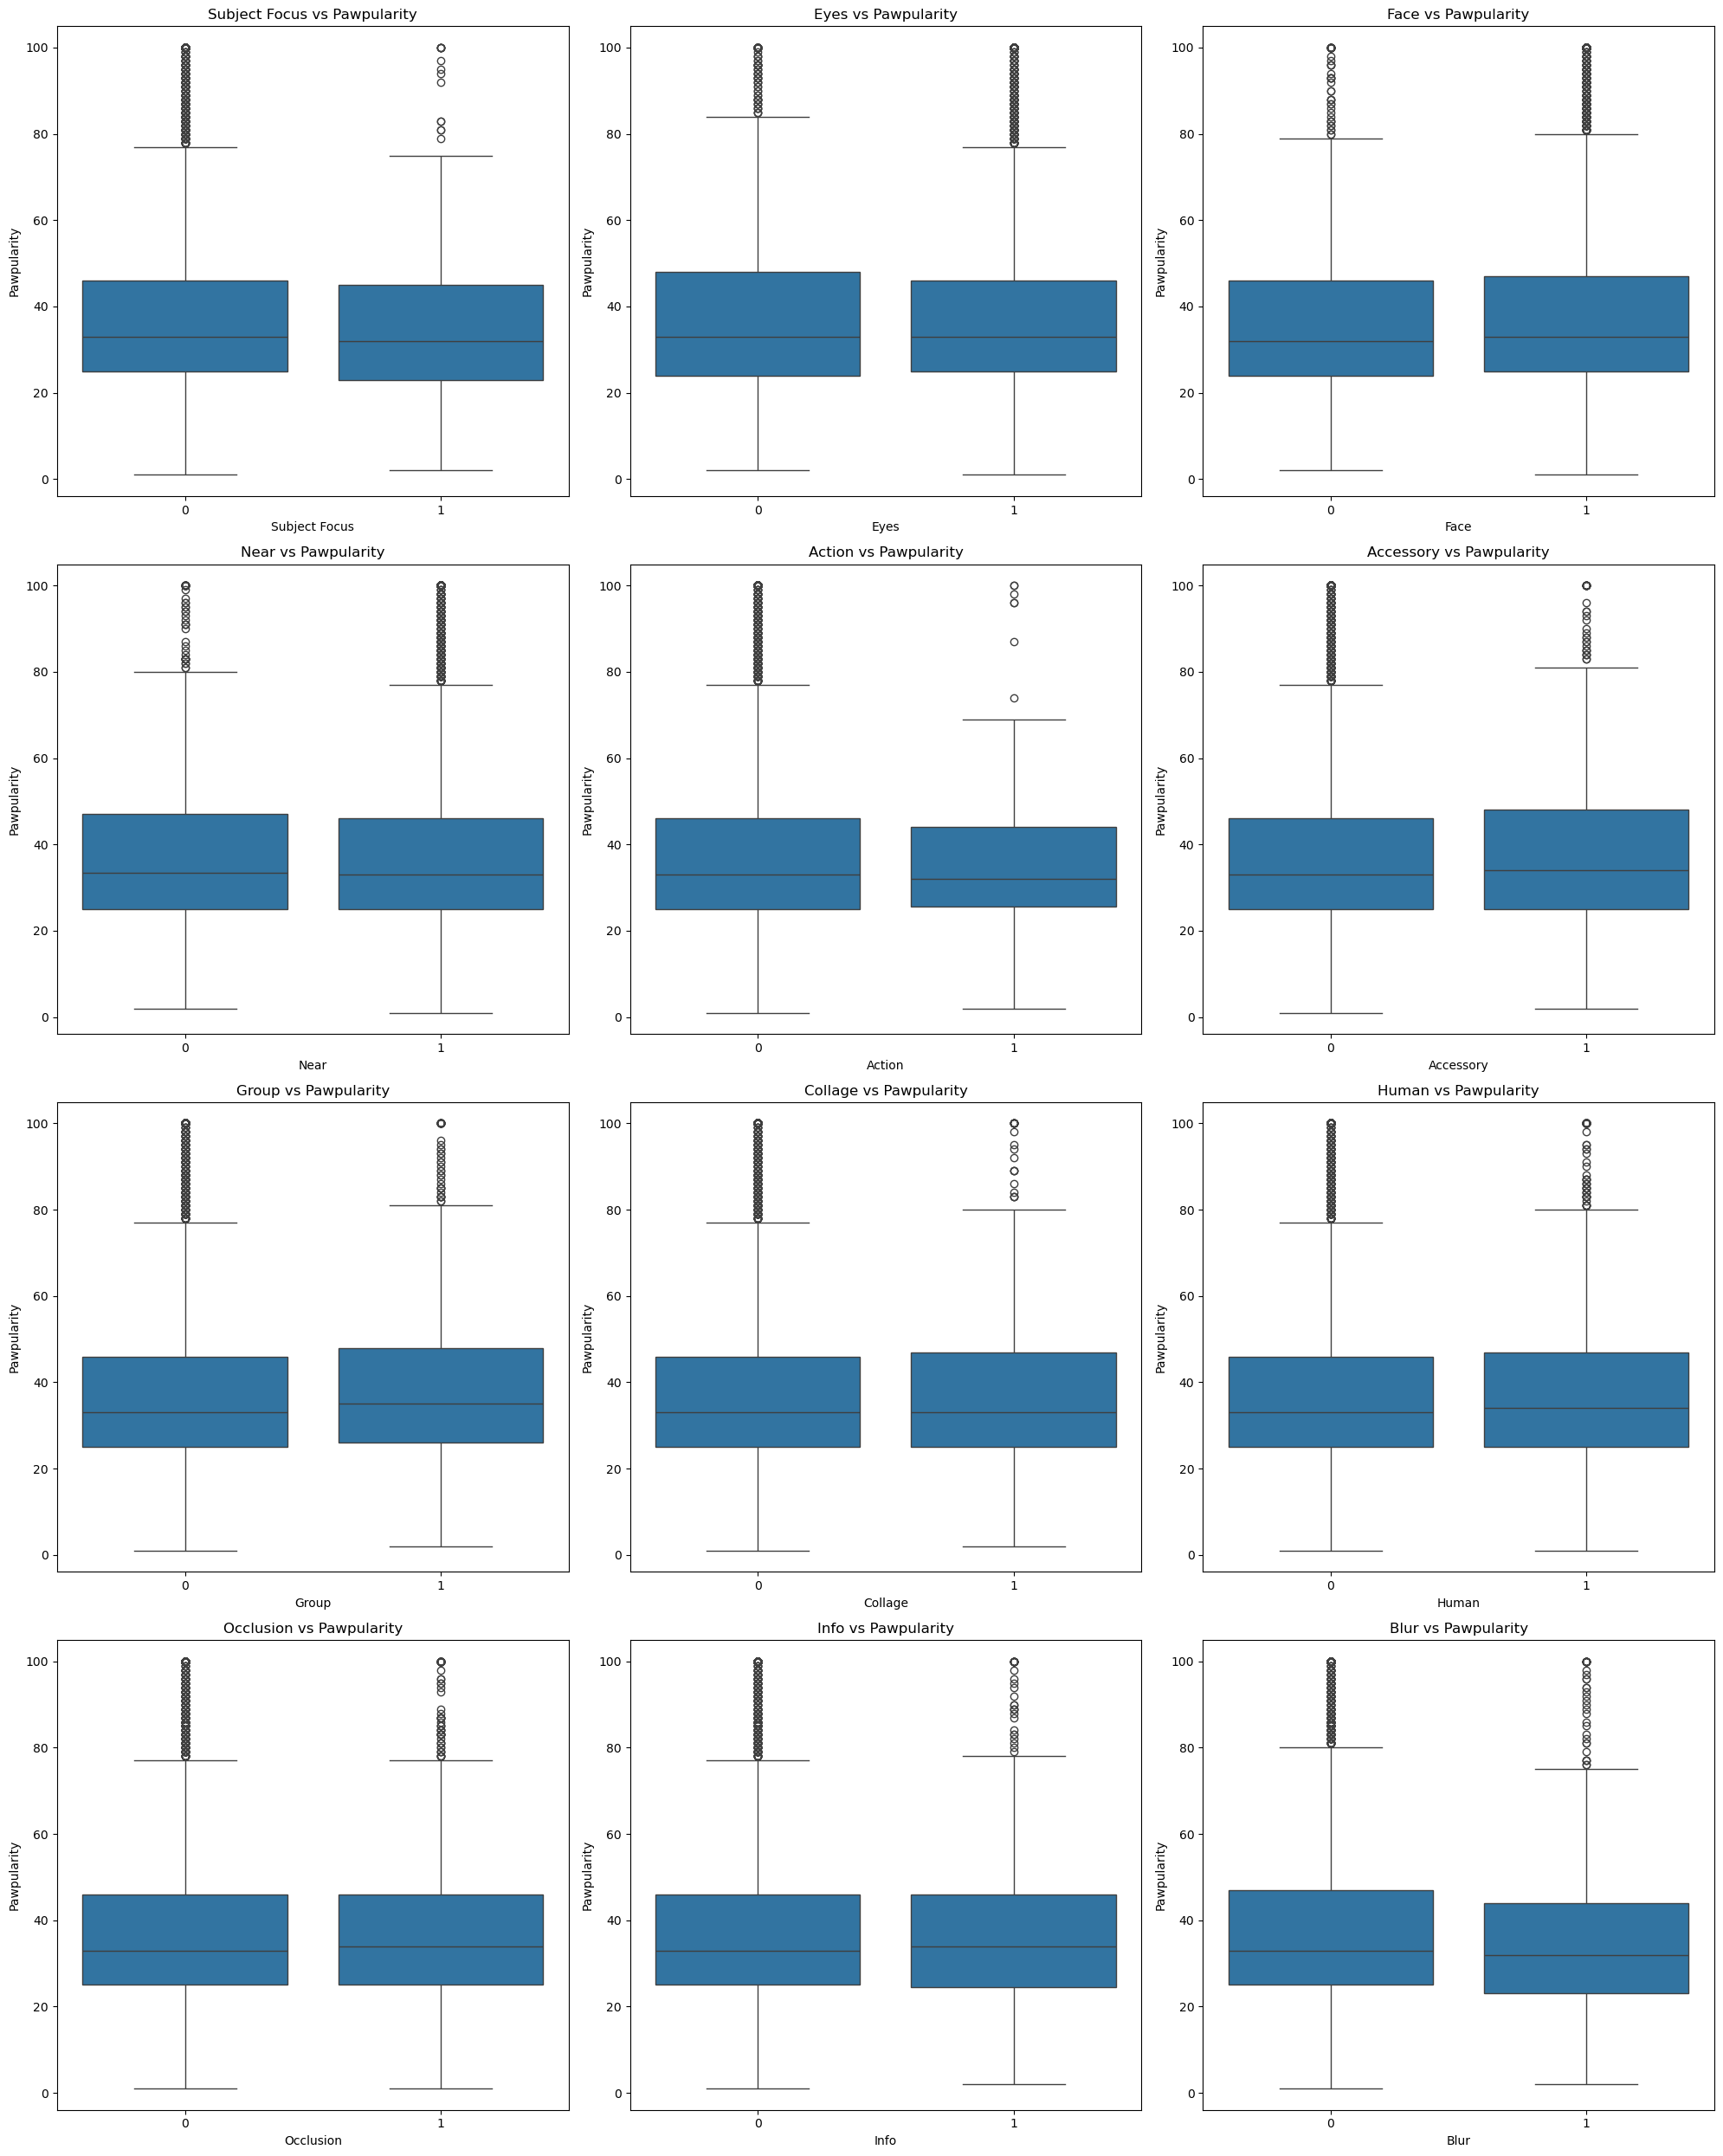

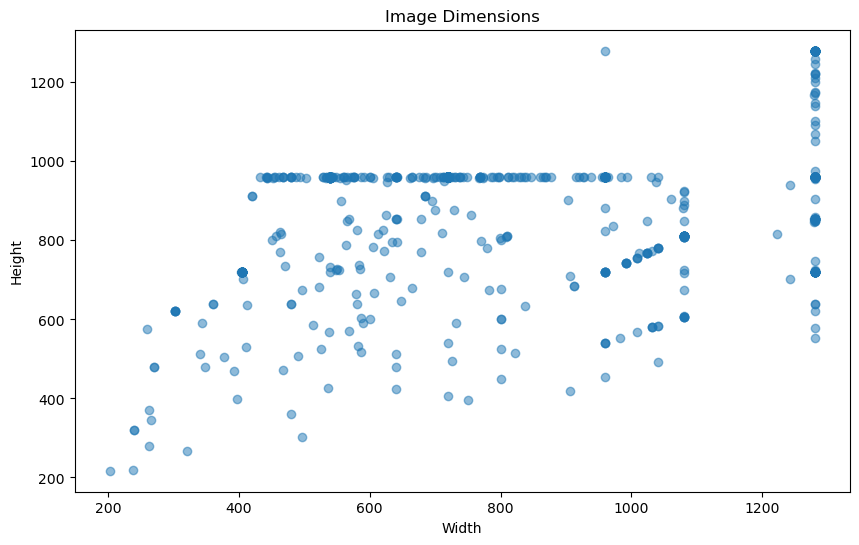

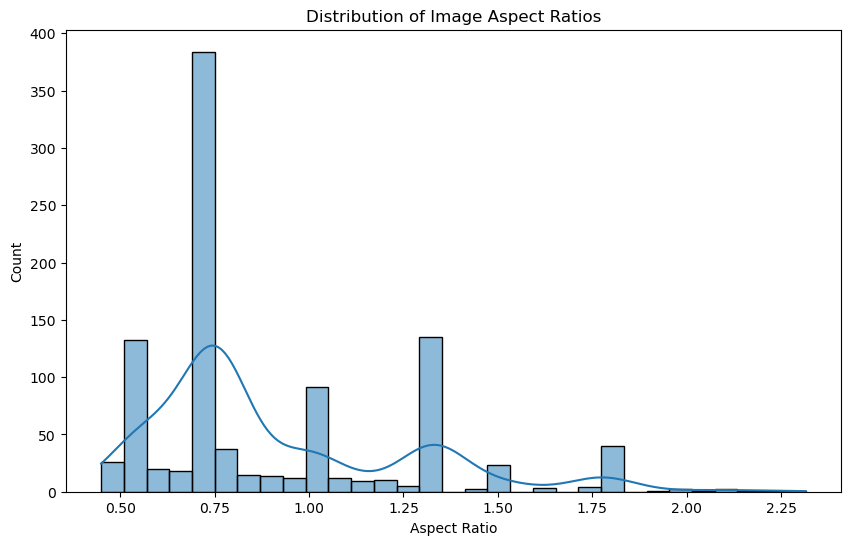

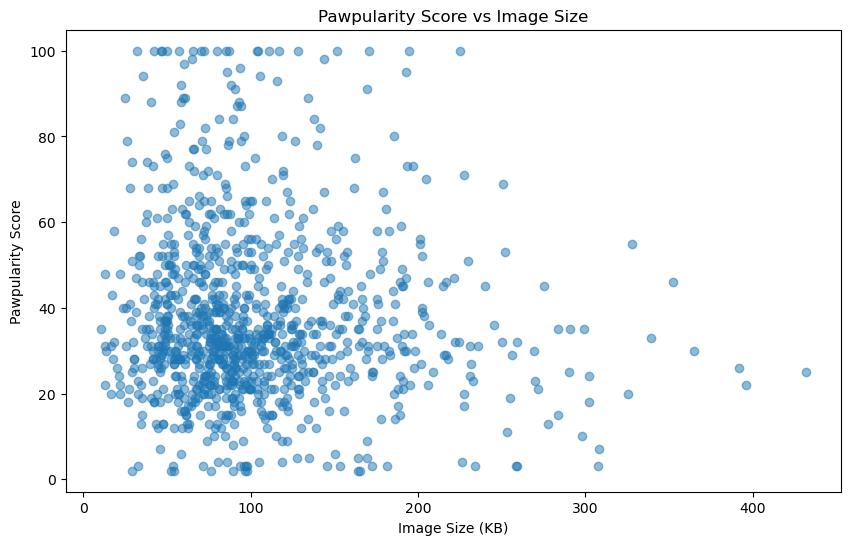

In [4]:
# 1. Distribution of Pawpularity Scores
plt.figure(figsize=(10, 6))
sns.histplot(train['Pawpularity'], kde=True)
plt.title('Distribution of Pawpularity Scores')
plt.xlabel('Pawpularity Score')
plt.ylabel('Frequency')
plt.show()

# 2. Correlation between features
correlation_matrix = train[categorical_col].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Features')
plt.show()

# 3. Relationship between individual features and Pawpularity
feature_cols = ['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory', 
                'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur']

fig, axes = plt.subplots(4, 3, figsize=(20, 25))
axes = axes.flatten()

for i, col in enumerate(feature_cols):
    sns.boxplot(x=col, y='Pawpularity', data=train, ax=axes[i])
    axes[i].set_title(f'{col} vs Pawpularity')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Pawpularity')

plt.tight_layout()
plt.show()

# 4. Image analysis
def analyze_image(image_path):
    img = Image.open(image_path)
    return {
        'width': img.size[0],
        'height': img.size[1],
        'aspect_ratio': img.size[0] / img.size[1],
        'size': os.path.getsize(image_path) / 1024  # size in KB
    }

image_dir = './data/train'  # Update this to your image directory path
image_data = []

for i, row in train.iterrows():
    if i > 1000:  # Limit to first 1000 images for speed
        break
    img_path = os.path.join(image_dir, row['Id'] + '.jpg')
    image_data.append(analyze_image(img_path))

image_df = pd.DataFrame(image_data)

# Plot image dimensions
plt.figure(figsize=(10, 6))
plt.scatter(image_df['width'], image_df['height'], alpha=0.5)
plt.title('Image Dimensions')
plt.xlabel('Width')
plt.ylabel('Height')
plt.show()

# Plot aspect ratio distribution
plt.figure(figsize=(10, 6))
sns.histplot(image_df['aspect_ratio'], kde=True)
plt.title('Distribution of Image Aspect Ratios')
plt.xlabel('Aspect Ratio')
plt.show()

# 5. Pawpularity score vs image features
plt.figure(figsize=(10, 6))
plt.scatter(image_df['size'], train['Pawpularity'].iloc[:1001], alpha=0.5)
plt.title('Pawpularity Score vs Image Size')
plt.xlabel('Image Size (KB)')
plt.ylabel('Pawpularity Score')
plt.show()

## 3. Architecture

- Convolutional Neural Network (CNN) from scratch
- Transfer Learning model using a pre-trained network (e.g., ResNet50)
- A traditional machine learning model (e.g., Random Forest) as a baseline

In [8]:
device = torch.device("mps" if torch.has_mps else "cpu")

# Custom Dataset
class PetFinderDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.dataframe.iloc[idx, 0] + '.jpg')
        image = Image.open(img_name).convert('RGB')
        pawpularity = self.dataframe.iloc[idx, -1]
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(pawpularity, dtype=torch.float32)

# Data Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets and dataloaders
train_df, val_df = train_test_split(train, test_size=0.2, random_state=42)


train_dataset = PetFinderDataset(train_df, './data/train', transform=transform)
val_dataset = PetFinderDataset(val_df, './data/train', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=0)


/var/folders/tt/bg81xkx10n788vrk6hd47xs80000gn/T/ipykernel_65247/3935971707.py:1: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  device = torch.device("mps" if torch.has_mps else "cpu")


In [15]:
# 1. CNN from scratch
# Update SimpleCNN to accept dropout_rate
class SimpleCNN(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 28 * 28, 64)
        self.fc2 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = torch.relu(self.conv3(x))
        x = x.view(-1, 64 * 28 * 28)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x.squeeze(1)

# Update TransferLearningModel to accept dropout_rate
class TransferLearningModel(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(TransferLearningModel, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        for param in self.resnet.parameters():
            param.requires_grad = False
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_ftrs, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.resnet(x).squeeze()

In [11]:
# Initialize models
cnn_model = SimpleCNN().to(device)
transfer_model = TransferLearningModel().to(device)

# Loss function and optimizers
criterion = nn.MSELoss()
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)
transfer_optimizer = optim.Adam(transfer_model.parameters(), lr=0.001)

# Training function
def train_model(model, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, pawpularity in train_loader:
            images = images.to(device)
            pawpularity = pawpularity.to(device).view(-1, 1)  # Reshape to match model output

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs.squeeze(), pawpularity)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

# Train models
print("Training CNN Model:")
train_model(cnn_model, cnn_optimizer)

print("\nTraining Transfer Learning Model:")
train_model(transfer_model, transfer_optimizer)

# Save models
torch.save(cnn_model.state_dict(), 'cnn_model.pth')
torch.save(transfer_model.state_dict(), 'transfer_model.pth')

print("Models trained and saved successfully.")

Training CNN Model:
Epoch 1/10, Loss: 466.39343864687027
Epoch 2/10, Loss: 430.4033210200648
Epoch 3/10, Loss: 424.2615098030336
Epoch 4/10, Loss: 427.40022339359405
Epoch 5/10, Loss: 422.97267624639693
Epoch 6/10, Loss: 423.93066307806197
Epoch 7/10, Loss: 423.1132994621031
Epoch 8/10, Loss: 427.3209763188516
Epoch 9/10, Loss: 423.73229488249746
Epoch 10/10, Loss: 422.6172807755009

Training Transfer Learning Model:


/Users/bosstation/anaconda3/envs/dl/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/bosstation/anaconda3/envs/dl/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([25, 1])) that is different to the input size (torch.Size([25])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/10, Loss: 458.51974641123127
Epoch 2/10, Loss: 433.84326461053666
Epoch 3/10, Loss: 431.93924620843705
Epoch 4/10, Loss: 433.75282158390166
Epoch 5/10, Loss: 430.54952012338947
Epoch 6/10, Loss: 431.6247369704708


KeyboardInterrupt: 

In [13]:
print("\nTraining Transfer Learning Model:")
train_model(transfer_model, transfer_optimizer)

# Save models
torch.save(cnn_model.state_dict(), 'cnn_model.pth')
torch.save(transfer_model.state_dict(), 'transfer_model.pth')

print("Models trained and saved successfully.")

Epoch 1/10, Loss: 433.3198411387782
Epoch 2/10, Loss: 430.0711894496795
Epoch 3/10, Loss: 428.0886446429837
Epoch 4/10, Loss: 427.73191925787154
Epoch 5/10, Loss: 427.07778309237574
Epoch 6/10, Loss: 428.3615421787385
Epoch 7/10, Loss: 425.45981447158323
Epoch 8/10, Loss: 426.611846739246
Epoch 9/10, Loss: 432.02829447100237
Epoch 10/10, Loss: 427.49896812438965
Models trained and saved successfully.


In [19]:
import optuna

class PyTorchModel:
    def __init__(self, model_class, **kwargs):
        self.model = model_class(**kwargs)
        self.model.to(device)

    def fit(self, train_loader, val_loader, num_epochs, learning_rate):
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        
        for epoch in range(num_epochs):
            self.model.train()
            for inputs, targets in train_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
        
        # Validation
        self.model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = self.model(inputs)
                val_loss += criterion(outputs, targets).item()
        
        return val_loss / len(val_loader)

def objective(trial, model_class, train_df, val_df):
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
    batch_size = trial.suggest_categorical('batch_size', [16, 64])
    num_epochs = trial.suggest_int('num_epochs', 5, 50)
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    train_dataset = PetFinderDataset(train_df, './data/train', transform=transform)
    val_dataset = PetFinderDataset(val_df, './data/train', transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    model = PyTorchModel(model_class, dropout_rate=dropout_rate)
    val_loss = model.fit(train_loader, val_loader, num_epochs, learning_rate)

    return val_loss

train_df, val_df = train_test_split(train, test_size=0.2, random_state=42)

# Create separate studies for CNN and ResNet
cnn_study = optuna.create_study(direction='minimize')
resnet_study = optuna.create_study(direction='minimize')

# Optimize for CNN
cnn_study.optimize(lambda trial: objective(trial, SimpleCNN, train_df, val_df), n_trials=1)

# Optimize for ResNet
resnet_study.optimize(lambda trial: objective(trial, TransferLearningModel, train_df, val_df), n_trials=1)

# Print results for CNN
print('Best CNN trial:')
cnn_trial = cnn_study.best_trial
print('  Value: ', cnn_trial.value)
print('  Params: ')
for key, value in cnn_trial.params.items():
    print('    {}: {}'.format(key, value))

# Print results for ResNet
print('\nBest ResNet trial:')
resnet_trial = resnet_study.best_trial
print('  Value: ', resnet_trial.value)
print('  Params: ')
for key, value in resnet_trial.params.items():
    print('    {}: {}'.format(key, value))

# Train final models with best hyperparameters
def train_final_model(model_class, best_params, model_name):
    best_model = PyTorchModel(model_class, dropout_rate=best_params['dropout_rate'])
    train_dataset = PetFinderDataset(train_df, 'train_images', transform=transforms.ToTensor())
    train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True)
    val_dataset = PetFinderDataset(val_df, 'train_images', transform=transforms.ToTensor())
    val_loader = DataLoader(val_dataset, batch_size=best_params['batch_size'], shuffle=False)

    best_val_loss = best_model.fit(train_loader, val_loader, best_params['num_epochs'], best_params['learning_rate'])
    print(f'Best {model_name} validation loss: {best_val_loss}')
    torch.save(best_model.model.state_dict(), f'best_{model_name}_model.pth')

train_final_model(SimpleCNN, cnn_study.best_params, 'cnn')
train_final_model(TransferLearningModel, resnet_study.best_params, 'resnet')

[I 2024-08-15 17:07:41,892] A new study created in memory with name: no-name-b71944c8-9eb8-49f6-916b-8126f7c5d8ef
[I 2024-08-15 17:07:41,893] A new study created in memory with name: no-name-0c656881-9572-4abd-b04a-a7537ff028b5
[W 2024-08-15 17:07:41,896] Trial 0 failed with parameters: {} because of the following error: TypeError("objective() missing 2 required positional arguments: 'train_df' and 'val_df'").
Traceback (most recent call last):
  File "/Users/bosstation/anaconda3/envs/dl/lib/python3.9/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/tt/bg81xkx10n788vrk6hd47xs80000gn/T/ipykernel_65247/2844579578.py", line 63, in <lambda>
    cnn_study.optimize(lambda trial: objective(trial, SimpleCNN), n_trials=1)
TypeError: objective() missing 2 required positional arguments: 'train_df' and 'val_df'
[W 2024-08-15 17:07:41,897] Trial 0 failed with value None.


TypeError: objective() missing 2 required positional arguments: 'train_df' and 'val_df'

In [ ]:
# Plot function
def plot_results(results, model_name):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    for idx, result in enumerate(results):
        lr = result['learning_rate']
        bs = result['batch_size']
        label_train = f"Train LR={lr}, BS={bs}"
        label_val = f"Val LR={lr}, BS={bs}"
        
        ax = axes[idx]
        ax.plot(result['train_losses'], label=label_train)
        ax.plot(result['val_losses'], label=label_val)
        ax.set_title(f"LR={lr}, BS={bs}")
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.legend()
        ax.grid(True)
    
    plt.suptitle(f'{model_name} Training and Validation Loss')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Plot CNN results
plot_results(cnn_results, "CNN")

# Plot ResNet results
plot_results(resnet_results, "ResNet")